## Requirements

Run the following setup script first. Change `remote_data_dir` to the name of the desired data folder in Solitabay.

In [1]:
remote_data_dir = 'raw_audio_data_20211007'

In [2]:
from pathlib import Path

if 'google.colab' in str(get_ipython()) and not Path('/content/data').is_dir(): # we only need to run this once
    !wget -q -O /content/setup.sh https://raw.githubusercontent.com/solita/ivves-machine-spraak/main/setup.sh
    !bash /content/setup.sh $remote_data_dir
else:
    print('This notebook is only meant to be run in Google Colab.')

This notebook is only meant to be run in Google Colab.


# Exploratory Analysis of Machine Audio Data

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
from math import ceil
import librosa, librosa.display
from IPython.display import Audio

import modules.utils as utl

data_folder = Path('/content/data/converted/')
# local:
#data_folder = Path('../data/converted/')
sample_rate, samples, names = utl.load_data(data_folder, channel=0)
print(names)

Found 8 files @ 48000 Hz in /Users/niko.laaksonen/projects/machine_spraak/ivves-machine-spraak/data/converted.
['ZOOM0004_Tr34.WAV', 'ZOOM0005_Tr34.WAV', 'ZOOM0005_LR.WAV', 'ZOOM0004_Tr2.WAV', 'ZOOM0004_Tr1.WAV', 'ZOOM0005_Tr1.WAV', 'ZOOM0005_Tr2.WAV', 'ZOOM0004_LR.WAV']


Some of the audio clips in our dataset contain stereo channels. In `utl.load_data` we decide how to convert these to mono for further processing (channel=0 or 1 correspond to keeping only the left or right channel respectively, while -1 takes the mean of the two). For our data it's dangerous to combine the channels since the phases of the signals are perfectly out of sync and thus cancel out:

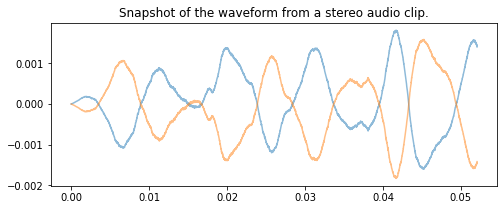

In [4]:
begin, window = 0, 5000
tmp_rate, tmp_sample = wavfile.read(data_folder / 'ZOOM0005_Tr34.WAV')
plt.figure(figsize=(8,3))
y=tmp_sample[begin:begin+window,:]
plt.plot(utl.times_like(y), y, alpha=0.5)
plt.title('Snapshot of the waveform from a stereo audio clip.')
plt.show()

## Waves

Let's next listen to one of our sample clips (you can try other clips by changing `n`):

In [5]:
n = 0
Audio(samples[n], rate=sample_rate)

We can then plot the familiar-looking waveforms for each of the clips.

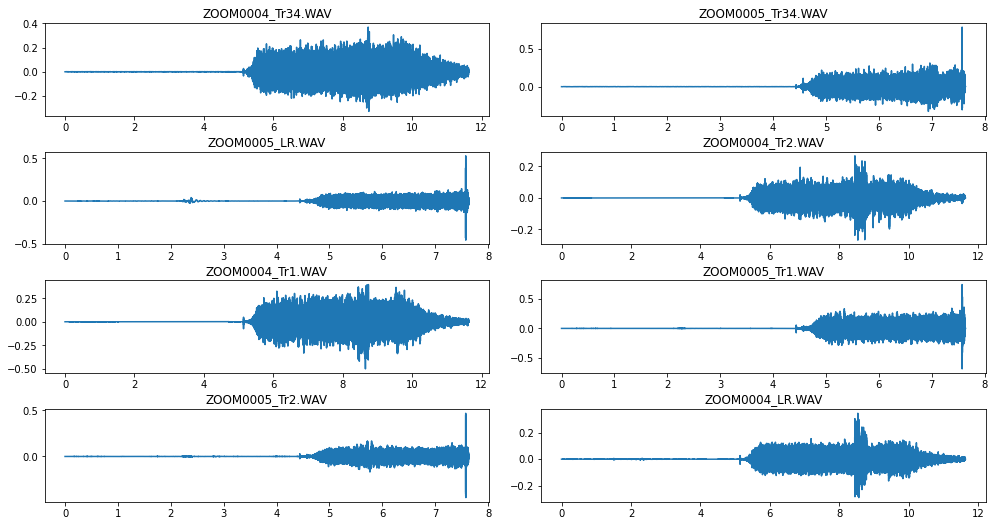

In [6]:
fig, axs = plt.subplots(4, 2, figsize=(14,8))
fig.tight_layout(pad=1.5, rect=[0, 0.03, 1, 0.95])

xs = [utl.times_like(s, sample_rate) for s in samples]

for n, ax in enumerate(axs.flat):
    ax.plot(xs[n], samples[n])
    ax.set_title(names[n])
plt.show()

## Spectrograms
> <https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html> 

Spectrograms are typically constructed by considering the Fourier transform of the input signal in a short window and then plotting the coefficients of the resultant frequencies versus time as a heatmap.

If you are interested in the mathematical formulation of a spectrogram and the (discrete) Fourier transform, then a short explanation is available [here](https://www.princeton.edu/~cuff/ele201/files/spectrogram.pdf).

In [7]:
show_sample = samples[7]
names[7]

'ZOOM0004_LR.WAV'

In the below heatmap the `x`-axis corresponds to time while `y` is the frequency axis.
The intensity of the colour shows the presence of the particular frequency at that instant of time.
For example, in the beginning we hear only background noise and thus most of the frequencies are filled with black
for the first five seconds or so. In the graph we can also detect the moment when the drill bit passes through the block
and the drill emits a loud chirp just before 9 seconds.

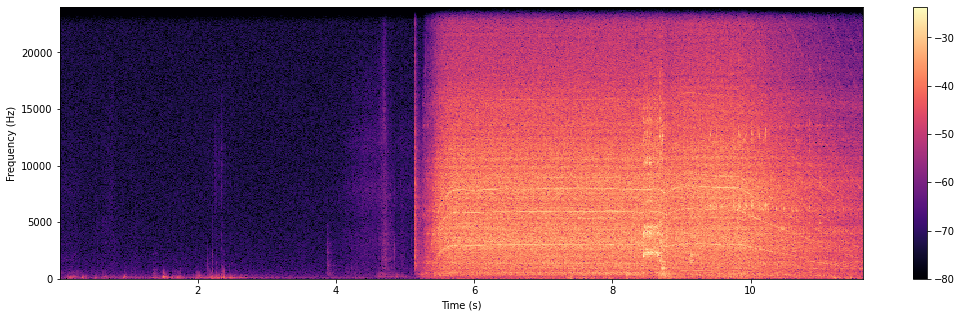

In [8]:
utl.plot_spec(show_sample, sample_rate, vmin=-80, vmax=None)

## Other features

### Mel Spectrogram
> <https://librosa.org/doc/main/generated/librosa.feature.melspectrogram.html#librosa.feature.melspectrogram>

This is a typical alternative to using raw FFT spectral data. For Mel spectrograms an alternative scaling step is used
where the frequency responses are scaled according to how they are perceived by the human ear (essentially: humans are better
at distinguishing variations in low rather than high frequencies; note the lower frequency range in the below plot)

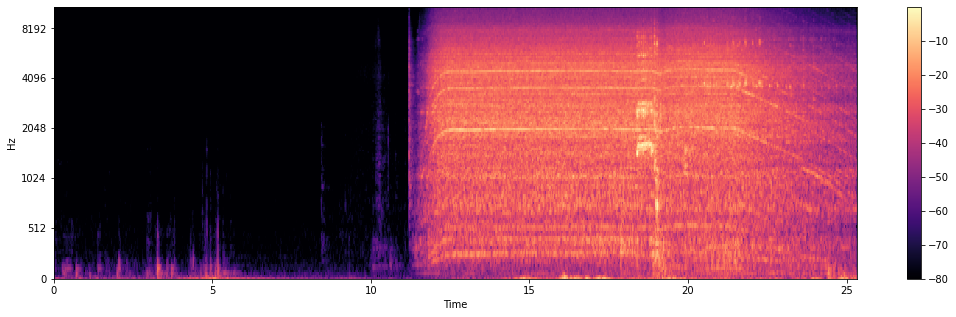

In [9]:
mel = librosa.feature.melspectrogram(y=show_sample, sr=sample_rate)
mel_dB = librosa.power_to_db(mel, ref=np.max)
fig, ax = plt.subplots(figsize=(18,5))
img = librosa.display.specshow(mel_dB, y_axis='mel', x_axis='time', ax=ax)
fig.colorbar(img, ax=ax)
plt.show()

### MFCC
> <https://librosa.org/doc/main/generated/librosa.feature.mfcc.html#librosa.feature.mfcc>

The Mel-frequency cepstral coefficients (MFCC) are obtained by computing an additional (discrete) Fourier transform
over the frequency axis of the Mel-spectrogram. They capture the periodicities (i.e. harmonics) present at each time
instant in the input signal. For example, in the Mel frequency plot we can see a strong recurring resonant structure
which shows up as bright lines at around 2048 Hz, 4096 Hz and beyond. This is what MFCC's will detect. For mathematical
reasons the first MFCC coefficient usually dominates the rest (and as such is not often very informative), so we drop
that below to ease with visualisation.

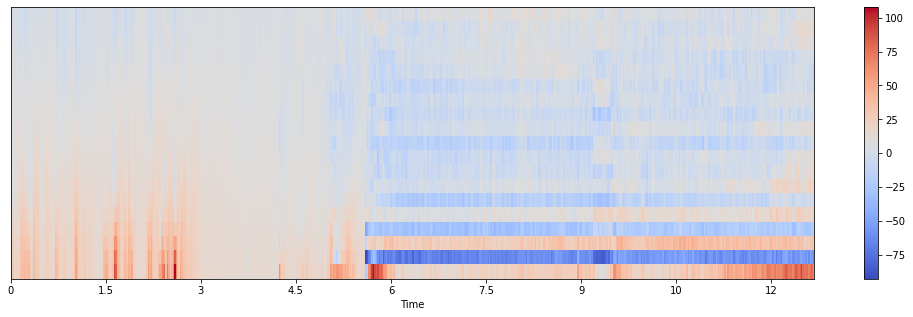

In [10]:
mfcc = librosa.feature.mfcc(y=show_sample, sr=sample_rate, hop_length=2**10, dct_type=2)
mfcc = mfcc[1:, :]
fig, ax = plt.subplots(figsize=(18,5))
img = librosa.display.specshow(mfcc, x_axis='time', ax=ax)
fig.colorbar(img, ax=ax)
plt.show()

### RMS Energy
> <https://librosa.org/doc/main/generated/librosa.feature.rms.html#librosa.feature.rms>

For machines which produces noises with wildly fluctuation noise profiles, the RMS Energy, which captures the instantaneous
energy of the input signal, is a very useful feature. Here the loud chirp of the drill bit passing through the plot shows up
as an easily distinghuishable event. Note the logarithmic scaling of the y-axis below.

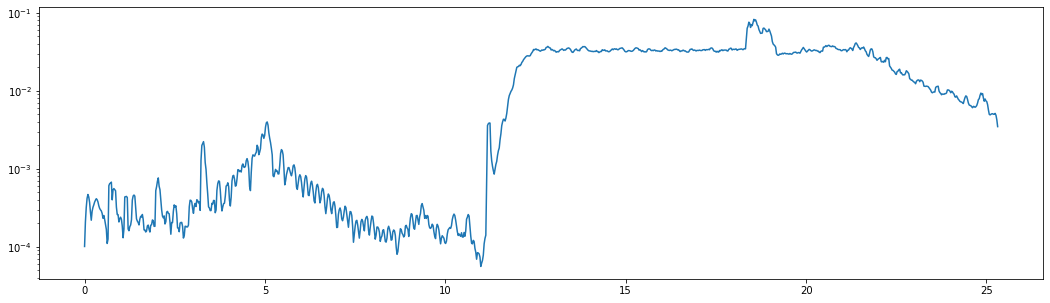

In [11]:
rms = librosa.feature.rms(y=show_sample)
fig, ax = plt.subplots(figsize=(18,5))
ax.semilogy(librosa.times_like(rms), rms[0])
plt.show()

### Spectral Centroid
> <https://librosa.org/doc/main/generated/librosa.feature.spectral_centroid.html#librosa.feature.spectral_centroid>

Spectral centroid is the "centre of the mass" of the frequencies of the input signal with respect to time.
It is related to how "bright" the sound is perceived as by humans, but in our case this feature is not very informative.

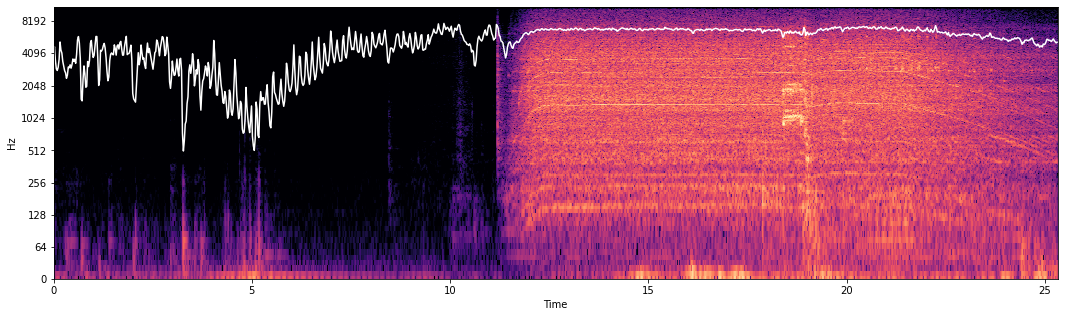

In [12]:
#TODO: we could add spectral spread, i.e. the second moment, here in the future
cent = librosa.feature.spectral_centroid(y=show_sample, sr=sample_rate)
S, phase = librosa.magphase(librosa.stft(y=show_sample))
fig, ax = plt.subplots(figsize=(18,5))
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='log', x_axis='time', ax=ax)
ax.plot(librosa.times_like(cent), cent.T, label='Spectral centroid', color='w')
plt.show()

### Zero-crossing rate (ZCR)
> <https://en.wikipedia.org/wiki/Zero-crossing_rate>

ZCR measures how often the input signal crosses zero. This is a much simpler feature compared to what we've shown above as it is not spectral,
but is computed directly based on the input waveform data. It can be seen as an approximation of the spectral centroid (dominant frequency).
Note that, as with the RMS energy, the moment when the drill bit passes through the block is detectable in the ZCR plot. However, clearly this
feature does not capture that phenomenon quite as well as the energy of the signal (*what kind of a rule would you come up with to detect the
drop in ZCR in the middle of the signal? It's certainly doable, but it is more complicated and less robust than relying on the RMS energy*).

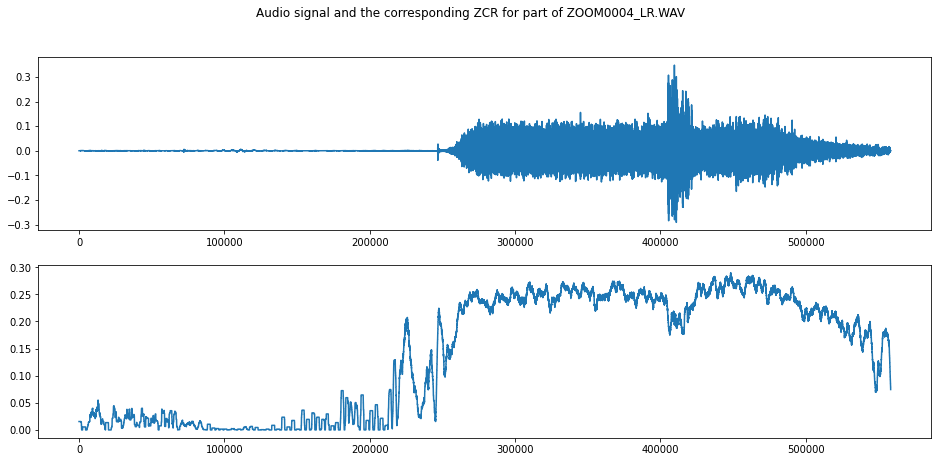

In [13]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,7))
ax1.plot(samples[7])
ax2.plot(utl.zero_cross_rate(show_sample, window=2000))
fig.suptitle(f'Audio signal and the corresponding ZCR for part of {names[7]}')
plt.show()